<h1><center>Modeling user with mouse moves (feature extraction in python)</center></h1>
<p><center><b>Author:</b> Michal Hucko</center></p>
<p><center><b>Supervisor:</b> prof. Mária Bieliková</center></p>

# Goal
* How to transform user mouse data into features describing user's behavior?
* We want to predict confusion based on those features.

In [6]:
# Environment setup (librarries and ploting)
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats 
from matplotlib import pyplot as plt

# Fiigure setup 
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

# Raw data
* We start with looking at our data.
* Data was gathered using mouse logger on index page of one of yeself's customer.
* Few visitors were extracted. We use only mouse-move events.

In [7]:
# Raw data
df = pd.read_csv("test_user_data.csv", parse_dates=['timestamp'], index_col=[0])
df.head()

,applicationId,attrs,classOnly,conversationId,cursorId,displayHeight,displayWidth,event,expressed,keyPressed,organisationId,relative,tagOnly,timestamp,url,userId,visitorId,xpath,xpos,ypos
0,ye-live-dss-pabk,NaN,NaN,ae8254d3-b964-4eb8-9eed-baf14c20143e,0,4624,1418,mousemove,NaN,NaN,cf44c5ba-e019-44c8-80e1-b1528425708a,header#page-t > div.wrapper:nth-child(4) > div...,NaN,2018-07-20 16:26:41.481,https://www.dsspabk.sk/dochodkove-fondy/stabil...,NaN,3c36dbbe-0e2e-4356-a618-8f5077f2b145,NaN,1142,321
1,ye-live-dss-pabk,NaN,NaN,ae8254d3-b964-4eb8-9eed-baf14c20143e,0,4624,1418,mousemove,NaN,NaN,cf44c5ba-e019-44c8-80e1-b1528425708a,header#page-t > div.wrapper.pad_t20:nth-child(...,NaN,2018-07-20 16:26:41.733,https://www.dsspabk.sk/dochodkove-fondy/stabil...,NaN,3c36dbbe-0e2e-4356-a618-8f5077f2b145,NaN,1136,308
2,ye-live-dss-pabk,NaN,NaN,ae8254d3-b964-4eb8-9eed-baf14c20143e,0,4624,1418,mousemove,NaN,NaN,cf44c5ba-e019-44c8-80e1-b1528425708a,header#page-t > div.wrapper.pad_t20:nth-child(...,NaN,2018-07-20 16:26:41.755,https://www.dsspabk.sk/dochodkove-fondy/stabil...,NaN,3c36dbbe-0e2e-4356-a618-8f5077f2b145,NaN,1106,305
3,ye-live-dss-pabk,NaN,NaN,ae8254d3-b964-4eb8-9eed-baf14c20143e,0,4624,1418,mousemove,NaN,NaN,cf44c5ba-e019-44c8-80e1-b1528425708a,div#page-h > div.top-menu:nth-child(2),NaN,2018-07-20 16:26:41.794,https://www.dsspabk.sk/dochodkove-fondy/stabil...,NaN,3c36dbbe-0e2e-4356-a618-8f5077f2b145,NaN,922,138
4,ye-live-dss-pabk,NaN,NaN,ae8254d3-b964-4eb8-9eed-baf14c20143e,0,4624,1418,mousemove,NaN,NaN,cf44c5ba-e019-44c8-80e1-b1528425708a,div#page-c > div.page_fund.product_page:nth-ch...,NaN,2018-07-20 16:26:41.400,https://www.dsspabk.sk/dochodkove-fondy/stabil...,NaN,3c36dbbe-0e2e-4356-a618-8f5077f2b145,NaN,1377,526


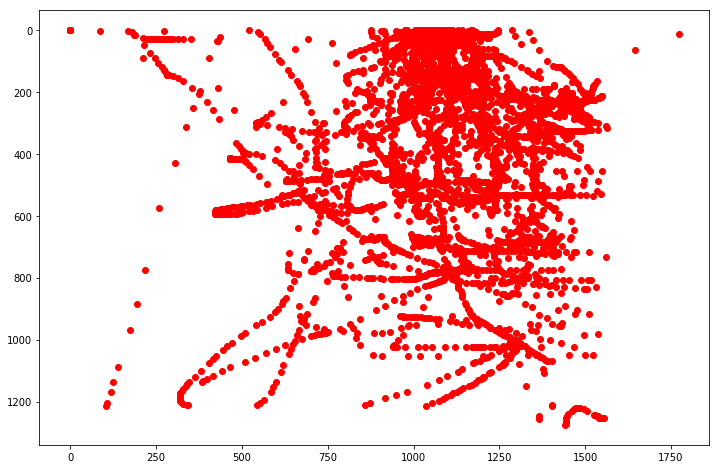

In [8]:
# Sample user plotting

# Choose sample user for sample date
target_id = "3c36dbbe-0e2e-4356-a618-8f5077f2b145"
target_date = "2018-06-25"
df_user = df.loc[df.visitorId == target_id, ['xpos', 'ypos', 'timestamp', 'event']]

# Plot data
plt.plot(df_user['xpos'],df_user['ypos'], 'ro')
plt.gca().invert_yaxis() # Invert axis because JS screen coordinates

## Spliting to moves
* Seen earlier analyzing as whole may be problematic. 
* Lets split data by timedeltas between each move [1]. We will set the treshold to 120 ms [1,2].
* Delete moves with less than 4 mouse-move events [1].

In [9]:
df_user['deltat'] = df_user.timestamp - df_user.timestamp.shift(1) # Compute row time - previous row time 
df_user.deltat = df_user.deltat / np.timedelta64(1, 'ms') # Transform it to miliseconds

# Delete records with same timedelta
df_user = df_user[df_user.deltat != 0].copy()

df_user['help']  = (df_user.deltat > 120).cumsum() # Cumulative sum of booleans split by 120 ms
moves = df_user.groupby('help').filter(lambda x: x.shape[0] >= 4) # Delete those with less than 4 mousemoves

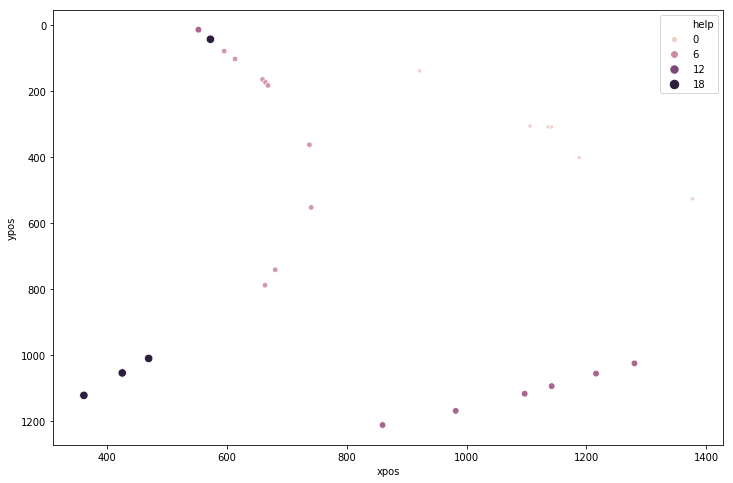

In [10]:
target_moves = moves[moves.help.isin(moves.help.unique()[:4])] # Get sample 4 moves

sns.scatterplot(target_moves['xpos'],target_moves['ypos'], hue=target_moves['help'], size=target_moves['help'])
plt.gca().invert_yaxis()

# Single user analysis
For each user separately we compute these features for each of his movements [1,2]:
* vertical speed (vy)
* hoorizontal speed (vx)
* speed (v)
* tangential speed (v_tan)
* acceleration (dtv)
* jerk (dtdtv)
* distance (dist)
* time (time)

In [8]:
def analyse_recods(x):
    """
    Function computes basic features from given user's mousemoves (x)
    """
    # Simple computation of features
    x['deltax'] = np.abs(x.xpos.shift(1) - x.xpos)
    x['deltay'] = np.abs(x.ypos.shift(1) - x.ypos)
    x['vx'] = x.deltax / x.deltat
    x['vy'] = x.deltay / x.deltat

    x['v_tan'] = np.sqrt(x.vx.pow(2) + x.vy.pow(2))
    x['dtv'] = x['v_tan'] / x.deltat
    x['dtdtv'] = x['dtv'] / x.deltat
    x['dist'] = np.sqrt(x.deltax.pow(2) + x.deltay.pow(2))
    
    # Add basic features to result dict
    result_dict = {
        "time": x.deltat.sum(),
        "dist": np.sqrt((x.deltax.pow(2) + x.deltay.pow(2))).sum(),
        "v": np.sqrt((x.deltax.pow(2) + x.deltay.pow(2)).sum()) / x.deltat.sum()
    }
    
    # For selected features compute means and add them into dict
    for feature in ['deltat', 'deltax', 'deltay', 'vx', 'vy', 'v_tan', 'dtv', 'dtdtv']:
        temp = {
            feature: x[feature].mean()
        }
        result_dict = {**result_dict, **temp}
    
    # Hack here return dataframe of given dict :) 
    return pd.Series(result_dict).to_frame().T

In [12]:
user_processed_moves = moves.groupby(['help']).apply(analyse_recods)
user_processed_moves.head()

,,time,dist,v,deltat,deltax,deltay,vx,vy,v_tan,dtv,dtdtv
help,,,,,,,,,,,,
1,0,1.500000e+01,1206.956850,4.630018e+01,2.500000e+00,180.800000,155.200000,2.245504,1.722023,3.519523,0.088964,0.002646
5,0,1.000847e+09,758.416323,3.492066e-07,1.112053e+08,27.750000,88.750000,0.538457,1.443522,1.568055,0.047360,0.002281
9,0,-5.940000e+02,1698.081759,-2.115488e+00,-8.485714e+01,121.166667,231.000000,1.212107,0.496773,1.404336,0.025917,0.000555
17,0,-5.500000e+02,1256.024894,-2.011137e+00,-1.375000e+02,106.333333,397.333333,0.525348,0.183775,1.338416,0.014800,0.000276
42,0,1.320000e+02,199.142754,9.446031e-01,3.300000e+01,32.000000,48.333333,-0.151908,-0.415829,0.482257,-0.004522,0.000043


# Problem
* How to represent each user in dataset? 
* Are average features sufficient?

# Histogram represantion
* Represent each feature as a histogram of its values for user. [2, 3]
* Store this histogram as a representation (model) of given user.

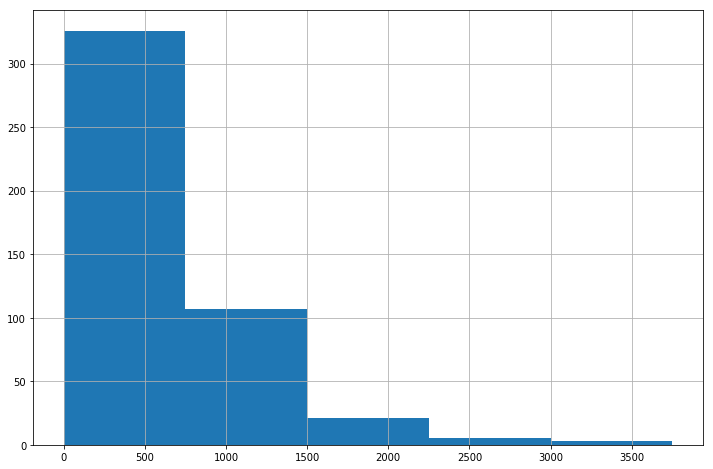

In [41]:
user_processed_moves.dist.hist(bins=5)

# Problem 
* How many bins should we use? 
* How to get bin values?

# Solution
* Estimating number of bins can be part of feature selection process.
* Estimate bin values acording to global data (data from all users) [2], estimating bin values acording to IQR of global data.

In [23]:
def get_bin_edges_for_columns(all_moves, columns):
    """
    Function extracts bin values for histograms from all given mouse moves.
    """
    result = {} 
    for column in columns: 
        result[column] = stats.mstats.mquantiles(all_moves[column].dropna(), np.linspace(0, 1, 5))
    return result

def get_histograms(user_data, bin_edges, columns):
    """
    Function generates histograms for given user data and bin values (bin edges).
    """
    result_dict = {}
    for feature in columns:
        x = get_feature_histogram(user_data, feature, bin_edges[feature])
        result_dict = {**result_dict, **x} # Syntactic sugar: concatenation of dictionairies
    return pd.Series(result_dict).to_frame().T # Same hack as before transformation dict to df

def get_feature_histogram(data, feature, bin_edges):
    """
    Function returns histogram transformed into dictionary
    """
    counts, _ = np.histogram(data[feature].dropna(), bins = bin_edges)
    result = {}
    for index, value in enumerate(counts):
        result[feature + "_bin_" +str(index)] = value
    return result

# On whole dataset
* Finally we run the whole analysis on the dataset.

In [11]:
def preprocess_user_mousemoves(user_data):
    """
    Function preprocess raw data. It computes time deltas and offsets in axis. It also filters out moves with few events.
    """
    user_data = user_data[['xpos', 'ypos', 'timestamp', 'event']]
    user_data = user_data[user_data.event.isin(['mousemove'])].sort_values(['timestamp']).copy()
    user_data = user_data.drop_duplicates()

    user_data['deltat'] = user_data.timestamp - user_data.timestamp.shift(1)
    user_data.deltat = user_data.deltat / np.timedelta64(1, 'ms')

    # Delete records with same timedelta
    user_data = user_data[user_data.deltat != 0].copy()
    
    user_data['help'] = (user_data.deltat > 120).cumsum()
    return user_data.groupby('help').filter(lambda x: x.shape[0] >= 4).groupby('help').apply(lambda x: analyse_recods(x)).reset_index(drop=True)

In [26]:
# Preprocess mouse data 
all_analysed_moves = df.groupby(['visitorId']).apply(lambda x: preprocess_user_mousemoves(x))

# For target features generate histograms' bin values 
columns = ['vx', 'vy', 'v', 'v_tan', 'dtv', 'dtdtv', 'dist', 'time']
bin_edges = get_bin_edges_for_columns(all_analysed_moves, columns)

# Generate histograms for each user
features = all_analysed_moves.reset_index().groupby(['visitorId']).apply(lambda x: get_histograms(x, bin_edges, columns))

In [28]:
features.index = features.index.levels[0]
features

,vx_bin_0,vx_bin_1,vx_bin_2,vx_bin_3,vy_bin_0,vy_bin_1,vy_bin_2,vy_bin_3,v_bin_0,v_bin_1,...,dtdtv_bin_2,dtdtv_bin_3,dist_bin_0,dist_bin_1,dist_bin_2,dist_bin_3,time_bin_0,time_bin_1,time_bin_2,time_bin_3
visitorId,,,,,,,,,,,,,,,,,,,,,
0dc38007-ea14-4aaf-bd39-b3fb204f48c2,44,31,24,11,50,34,18,8,27,27,...,18,10,41,31,24,14,30,36,36,8
189249c9-d577-48da-a662-dff005e9bbe5,12,15,8,10,20,11,7,7,7,15,...,7,7,10,17,11,7,11,15,15,4
3c36dbbe-0e2e-4356-a618-8f5077f2b145,28,44,57,54,28,36,51,68,60,38,...,67,52,33,49,53,48,42,42,23,76
4c0a6ae9-04c6-4266-91e3-7883549f055c,18,11,10,32,9,21,16,25,18,17,...,13,35,19,11,10,31,18,9,21,23
7248fd19-ddb4-4db4-b044-67187797fffd,15,16,18,10,10,15,25,9,5,20,...,12,13,14,9,19,17,16,15,22,6


# Conclusion
* We showed a method for user representation using histogram of features.
* We mentioned some problems connected with this approach. 
* We showed implementation in Python.

# Python essentials
* Map, reduce, filter: http://book.pythontips.com/en/latest/map_filter.html

**Basic Data science**
* Pandas: https://pandas.pydata.org/
* Numpy: http://www.numpy.org/
* Scipy: https://www.scipy.org/

**Plotting and visualisation**
* Matplotlib: https://matplotlib.org/
* Seaborn: https://seaborn.pydata.org/

**Jupyter**
* jupyter notebook: http://jupyter.org/
* jupyter lab: https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html
* google collab: https://colab.research.google.com/

# References
[1] GAMBOA, Hugo; FRED, Ana. A behavioral biometric system based on human-computer interaction. In: Biometric Technology for Human Identification. International Society for Optics and Photonics, 2004. p. 381-393.

[2] KRÁTKY, Peter; CHUDÁ, Daniela. Recognition of web users with the aid of biometric user model. Journal of Intelligent Information Systems, 2018, 1-26.

[3] AHMED, Ahmed Awad E.; TRAORE, Issa. A new biometric technology based on mouse dynamics. IEEE Transactions on dependable and secure computing, 2007, 4.3: 165-179.
